In [1]:
from __future__ import division, print_function
import os
import sys

import numpy as np
from gwbench import basic_relations as br

import numpy as np
from gwbench import network
from gwbench import snr

import matplotlib.pyplot as plt
import numpy as np

from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

import lalsimulation as ls
import lal


In [2]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
bilby_path = '../bilby_3g'
if os.path.isdir(bilby_path):
  import sys
  sys.path.append(bilby_path)
  print('Added path: ', bilby_path)

import bilby

import bilby.gw.utils as gwutils

bilby.gw.cosmology._set_default_cosmology()
cosmo = bilby.gw.cosmology.DEFAULT_COSMOLOGY


Added path:  ../bilby_3g


In [4]:
m1src = 50.0
m2src= 35.0

redshift=0.2

theta_jn_deg=0.0

ra_deg=60.0
dec_deg=60.0
psi_deg=60.0

fsample=2048.0
fmin=20.
fref=20.
fmax=2048.

waveform='IMRPhenomXAS'
waveform_det='IMRPhenomXAS'

margPhase = False
seed = 1290643798

# ifo_list= ['CE', 'CES', 'ET1', 'ET2', 'ET3']
# ifo_list= ['CE20']
ifo_list=['L1']



In [5]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
sampling_frequency = fsample
sampler = 'dynesty'
# Specify the output directory and the name of the simulation.

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(seed)


In [6]:
# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
bilby.gw.cosmology._set_default_cosmology()
cosmo = bilby.gw.cosmology.DEFAULT_COSMOLOGY
mtotal = m1src+m2src
q=m2src/m1src

z=redshift
dL=cosmo.luminosity_distance(z).value

tilt_1=0.
tilt_2=0.
chi_1=0.
chi_2=0.
phi_12=0.
phi_jl=0.


theta_jn_rad = theta_jn_deg*np.pi/180.0
ra_rad = ra_deg*np.pi/180.0
dec_rad = (dec_deg*np.pi/180.0)
psi_rad = psi_deg*np.pi/180.0
phase=0.0
# gps_time=1577491218.0
gps_time= 0.

m1_det = m1src*(1+z)
m2_det = m2src*(1+z)
total_mass_det = m1_det+m2_det

Mc_det = bilby.gw.conversion.component_masses_to_chirp_mass(m1_det, m2_det)
eta_det = bilby.gw.conversion.chirp_mass_and_total_mass_to_symmetric_mass_ratio(Mc_det, total_mass_det)

approx = waveform
approx_det = waveform_det
label = 'mtotal%.1f_q%.1f_z%.1f_iota%.1f_%s' %(mtotal, 1./q, redshift, theta_jn_deg, approx)
# bilby.core.utils.setup_logger(outdir=outdir, label=label)
fref=fref
fmin=fmin
fmax=fmax

duration = 16.

print(Mc_det)
print(eta_det)


43.563251770024294
0.24221453287197214


# Bilby Setup

In [7]:
# injection/simulation of a waveform
injection_parameters = dict(
	chirp_mass = Mc_det, mass_1=m1_det, mass_2=m2_det, chi_1=chi_1, chi_2=chi_2,
	luminosity_distance=dL, theta_jn=theta_jn_rad, psi=psi_rad,
	phase=phase, geocent_time=gps_time, ra=ra_rad, dec=dec_rad, reference_frequency=fref, minimum_frequency=fmin)


In [8]:
# Fixed arguments passed into the source model
# approx: IMRPhenomPv2: standard, (2,2), IMRPhenomXPHM (l,m)=(2,2),...(4,4)
waveform_arguments = dict(waveform_approximant=approx, reference_frequency=fref, minimum_frequency=fmin)

In [9]:
waveform_generator = bilby.gw.WaveformGenerator(
	duration=duration, sampling_frequency=sampling_frequency,
	frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
	parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
	waveform_arguments=waveform_arguments, start_time=injection_parameters['geocent_time'])#,start_time=injection_parameters['geocent_time'] - duration + 2.0)


11:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Bilby Waveform

In [10]:
hp_bilby = waveform_generator.frequency_domain_strain(injection_parameters)['plus']
hc_bilby = waveform_generator.frequency_domain_strain(injection_parameters)['cross']
f_bilby = waveform_generator.frequency_array

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(18.0, 50.0)

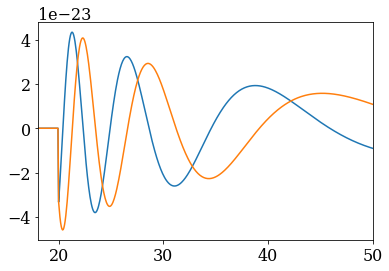

In [11]:
plt.plot(f_bilby, hp_bilby)
plt.plot(f_bilby, hc_bilby)
plt.xlim(18, 50)

In [12]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(ifo_list)
for ifo in ifos:
	ifo.set_strain_data_from_zero_noise(
		sampling_frequency=sampling_frequency, duration=duration)#,
		#start_time=injection_parameters['geocent_time'])
	ifo.inject_signal_from_waveform_generator(parameters=injection_parameters, waveform_generator=waveform_generator)



11:39 bilby INFO    : Injected signal in L1:
11:39 bilby INFO    :   optimal SNR = 38.24
11:39 bilby INFO    :   matched filter SNR = 38.24+0.00j
11:39 bilby INFO    :   chirp_mass = 43.563251770024294
11:39 bilby INFO    :   mass_1 = 60.0
11:39 bilby INFO    :   mass_2 = 42.0
11:39 bilby INFO    :   chi_1 = 0.0
11:39 bilby INFO    :   chi_2 = 0.0
11:39 bilby INFO    :   luminosity_distance = 1011.4196559461382
11:39 bilby INFO    :   theta_jn = 0.0
11:39 bilby INFO    :   psi = 1.0471975511965976
11:39 bilby INFO    :   phase = 0.0
11:39 bilby INFO    :   geocent_time = 0.0
11:39 bilby INFO    :   ra = 1.0471975511965976
11:39 bilby INFO    :   dec = 1.0471975511965976
11:39 bilby INFO    :   reference_frequency = 20.0
11:39 bilby INFO    :   minimum_frequency = 20.0


(18.0, 50.0)

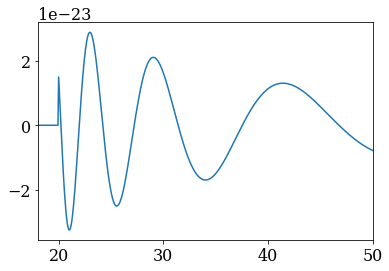

In [13]:
plt.plot(ifo.frequency_array,np.real(ifo.frequency_domain_strain))
plt.xlim(18, 50)


# GWBENCH Setup

In [14]:
def get_network_response(inj_params, f_min = 5.0, f_max=4096., network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = f_min
    f_max = f_max
    d_f = fsample**-1
    d_f = 1/duration
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )



    # compute the WF polarizations
    net.calc_wf_polarizations()   
    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()

    # calculate the network and detector SNRs
    net.calc_snrs()
    
    return net


In [15]:
# set the injection parameters
inj_params = {
    'Mc':    Mc_det,
    'eta':   eta_det,
    'chi1x': chi_1,
    'chi2x': chi_2,
    'chi1y': chi_1,
    'chi2y': chi_2,
    'chi1z': chi_1,
    'chi2z': chi_2,
    'DL':    dL,
    'tc':    0.,
    'phic':  phase,
    'iota':  0.,
    'ra':    ra_rad,
    'dec':   dec_rad,
    'psi':   psi_rad,
    'gmst0': bilby.gw.utils.greenwich_mean_sidereal_time(gps_time)
    }


deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
param_list = deriv_symbs_string.split()

network_spec = ['aLIGO_L']
# network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
# network_spec = ['CE2-20-CBO_C']



In [16]:
net1 = get_network_response(inj_params=inj_params, f_min=fmin, f_max=fmax, network_spec=network_spec, approximant=approx,\
    cond_num=1e25)
print("SNR = ", net1.snr)

Polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate SNRs.
SNRs calculated.
SNR =  39.725778257205


# Gwbench Results

In [17]:
print(net1.inj_params)
net1.snr

{'Mc': 43.563251770024294, 'eta': 0.24221453287197214, 'chi1x': 0.0, 'chi2x': 0.0, 'chi1y': 0.0, 'chi2y': 0.0, 'chi1z': 0.0, 'chi2z': 0.0, 'DL': 1011.4196559461382, 'tc': 0.0, 'phic': 0.0, 'iota': 0.0, 'ra': 1.0471975511965976, 'dec': 1.0471975511965976, 'psi': 1.0471975511965976, 'gmst0': -45991.088355155895}


39.725778257205

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


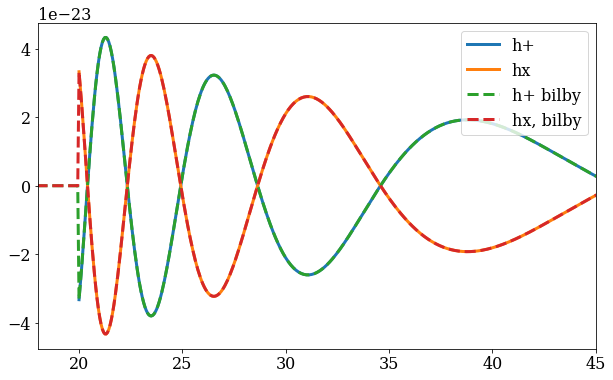

In [18]:
f, ax= plt.subplots(figsize=(10,6))

hf = net1.hfp + 1.j*net1.hfc
# hf_m = net1.hfp - 1.j*net1.hfc

plt.plot(net1.f, (net1.hfp), lw=3, label='h+')
plt.plot(net1.f, np.imag(net1.hfc), lw=3, label='hx')


plt.plot(f_bilby, hp_bilby, ls='--', lw=3, label='h+ bilby')
plt.plot(f_bilby, np.imag(hc_bilby), lw=3, linestyle='--', label='hx, bilby')


plt.xlim(18, 45)
plt.legend()

# F_+, F_x

In [19]:
#Gwbench
print(net1.detectors[0].Fp)
print(net1.detectors[0].Fc)


0.04452083520423405
-0.7389764752847225


In [20]:
# Bilby

ra = injection_parameters['ra']
dec = injection_parameters['dec']
time = injection_parameters['geocent_time']
psi = injection_parameters['psi']
mode = 'plus'

polarization_tensor = gwutils.get_polarization_tensor(ra, dec, time, psi, mode)
print(polarization_tensor[0,0] - polarization_tensor[1,1])
print(polarization_tensor[0,1] + polarization_tensor[1,0])

print(polarization_tensor)
print(np.einsum('ij,ij->', ifo.geometry.detector_tensor, polarization_tensor))

print()

print(ifo.geometry.detector_tensor)
print(ifo.geometry.detector_tensor[0,0] - ifo.geometry.detector_tensor[1,1])

1.507818134244134
-0.8614577610333192
[[ 0.69140907 -0.43072888 -0.4585854 ]
 [-0.43072888 -0.81640907 -0.15515937]
 [-0.4585854  -0.15515937  0.125     ]]
0.044520172132722524

[[ 0.41128776  0.14041439  0.24716864]
 [ 0.14041439 -0.10922465 -0.18173217]
 [ 0.24716864 -0.18173217 -0.3020631 ]]
0.5205124107877648


# LAL Waveform

In [21]:
def compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant):
    
    # These have to be set to 0 by definition
    inc, phiC  = 0., 0.
    
    # Generate the modes hlm 
    hlms = ls.SimInspiralChooseFDModes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, f_low, phiC, distance, inc, None, approximant)
    
    return hlms    


In [22]:
approximant = ls.IMRPhenomXAS

deltaF, f_low, f_max = 1/duration, fmin, fmax
freq_range = np.linspace(0, f_max, int(f_max/deltaF))

approximant = ls.IMRPhenomXAS
hplus , hcross  = ls.SimInspiralChooseFDWaveform(m1=m1_det, m2=m2_det, \
                                                S1x=chi_1, S1y=chi_1, S1z=chi_1, S2x=chi_2, S2y=chi_2, S2z=chi_2, \
                                                distance=dL, inclination=0., phiRef=phase, longAscNodes=0., eccentricity=0., meanPerAno=0., \
                                                deltaF=deltaF, f_min=f_low, f_max=f_max, f_ref=fref, LALpars=None, approximant=approximant)
hlm_1 = hplus.data.data[:-1] + 1.j*hcross.data.data[:-1]
# hlm_1 = -hlm_1 # Flipped to try and fix convention issues

(10.0, 65.0)

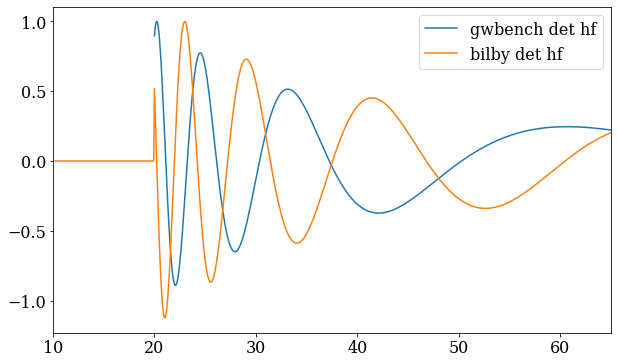

In [23]:
f, ax= plt.subplots(figsize=(10,6))
# plt.plot(freq_range, np.real(hlm_1)/ np.max(np.real(hlm_1)), label='lal')


hf_gwbench_det = net1.detectors[0].hf
plt.plot(net1.f, np.real(hf_gwbench_det)/np.max(np.real(hf_gwbench_det)), label='gwbench det hf')


hf_bilby_det = np.real(ifo.frequency_domain_strain)
plt.plot(ifo.frequency_array, hf_bilby_det / np.max(hf_bilby_det), label='bilby det hf')

plt.legend()
# plt.semilogx()
plt.xlim(10, 65)